Things to check:
1. $\chi^2$ histogram
2. Error histogram
3. Residuals histogram for individual runs
4. Look at longer run

In [1]:
%load_ext autoreload
%autoreload
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.linalg as linalg
from scipy.stats import linregress

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from BandPass import *
from fitFunctions import *
from partialfitting import *
from tqdm import *
from fitphases import *
from fitGammaRatio import *
from chi2 import *
from corrphase import *
from corr2Pi import *

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#dirName = "/home/jean/RomalisResearch/ncrescini/18-10-30 1/" # Directory with data
dirName = "/home/jean/RomalisResearch/FakeData/18-12-10/" # Directory with data
files = [f for f in os.listdir(dirName) if f.endswith('.txt')]
gHe = 20378.9
gNe = 2*np.pi*336.1
gRatio = gHe/gNe

ks1 = 0 # First file index
ks2 = 20 # Last file index
n_ave = 10 # Number of points to average over

dt = 1e-3*n_ave
Fs = 1/dt
D1Start = 50 # Start of first detection (currently only uses this)
D1EndTimes = [95] # End of first detection (currently only uses this)
D2Start = 200 # Start of second detection (currently doesn't use this)
D2EndTimes = [240] # End of second detection (currently doesn't use this)
absSigma = True

delta_t = 2/1.56 # Time length of a subsectino

In [3]:
def chi2(expected, observed, error, ddof):
    return np.sum((expected-observed)**2 / error**2 / (len(expected)-ddof))

phi1_fit_arr = np.empty((ks2+1-ks1, 2))
phi2_fit_arr = np.empty((ks2+1-ks1, 2))
phi1_fiterr_arr = np.empty((ks2+1-ks1, 2))
phi2_fiterr_arr = np.empty((ks2+1-ks1, 2))
chi21_arr = np.empty(ks2+1-ks1)
chi22_arr = np.empty(ks2+1-ks1)
cp_fit_arr = np.empty((ks2+1-ks1, 2))
cp_fiterr_arr = np.empty((ks2+1-ks1, 2))
cpchi2_arr = np.empty(ks2+1-ks1)
r_arr = np.empty(ks2+1-ks1)

phi1_arr_all = []
phi1_fitresults_arr = []
phi2_arr_all = []
phi2_fitresults_arr = []
phi1_fitresults_arr = []
cp_arr_all = []
cp_fitresults_arr = []
phi1_err_all = []
phi2_err_all = []
cp_err_all = []

for k_ind in range(ks1, ks2+1):
    print(k_ind)
    k = k_ind - ks1 # file number
    paraOut_arr, errtout_arr, dataPar_x, dataPar_y, datafit = initialfitting(k_ind, k, n_ave, dirName, files, dt, Fs, D1Start, D1EndTimes, D2Start, D2EndTimes, delta_t)
    phi1_err = errtout_arr[:,5]; phi2_err = errtout_arr[:,2]
    times = np.mean(dataPar_x, axis=1)
    phi1_arr, phi2_arr, fit_freq1, fit_freq2, fit_err1, fit_err2 = correctPhases(times, paraOut_arr, errtout_arr)
    phi1_fit_results, phi1_fit_arr[k], phi1_fiterr_arr[k], chi21_arr[k], phi2_fit_results, phi2_fit_arr[k], phi2_fiterr_arr[k], chi22_arr[k] = fitPhases(times, phi1_arr, phi1_err, phi2_arr, phi2_err, absSigma)
    
    r_arr[k] = fitGammaRatio(phi1_arr, phi2_arr, gHe/gNe)

    cp_val, cp_err, cp_fit_results, cp_fit_arr[k], cp_fiterr_arr[k], cpchi2_arr[k] = corrphase(times, phi1_arr, phi2_arr, phi1_err, phi2_err, r_arr[k], absSigma)

    phi1_arr_all.append(phi1_arr)
    phi2_arr_all.append(phi2_arr)
    cp_arr_all.append(cp_val)
    phi1_err_all.append(phi1_err)
    phi2_err_all.append(phi2_err)
    cp_err_all.append(cp_err)
    phi1_fitresults_arr.append(phi1_fit_results)
    phi2_fitresults_arr.append(phi2_fit_results)
    cp_fitresults_arr.append(cp_fit_results)

phi1_fitresults_arr = np.array(phi1_fitresults_arr)
phi1_arr_all = np.array(phi1_arr_all)
phi2_fitresults_arr = np.array(phi2_fitresults_arr)
phi2_arr_all = np.array(phi2_arr_all)
cp_arr_all = np.array(cp_arr_all)
phi1_err_all = np.array(phi1_err_all)
phi2_err_all = np.array(phi2_err_all)
cp_fitresults_arr = np.array(cp_fitresults_arr)
cp_err_all = np.array(cp_err_all)

0


/home/jean/RomalisResearch/pulsed_fitter_current/fitFunctions.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  s_sq = np.sum( ((fitval-y)/sigma)**2 )/(len(x) - 2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


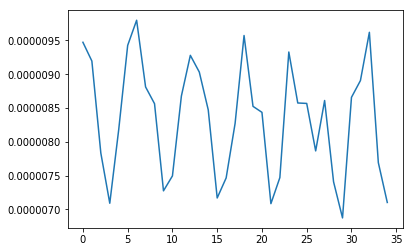

In [4]:
#plt.plot(dataPar_x.flatten(), dataPar_y.flatten()-datafit)
plt.plot(phi1_err)

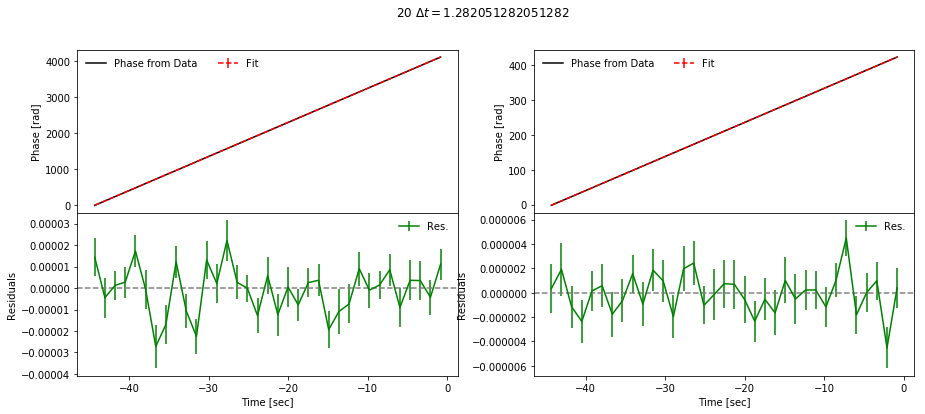

In [5]:
i=0

mpl.rcParams['figure.figsize'] = [15.0, 6.0]
f, ax_arr = plt.subplots(2, 2)
f.suptitle(str(k_ind)+' $\Delta t = '+str(delta_t)+"$")
ax_arr[0,0].plot( times, phi1_arr_all[i], c="black", label="Phase from Data")
ax_arr[0,0].errorbar( times, phi1_fitresults_arr[i], (phi1_fiterr_arr[i][1]+phi1_fiterr_arr[i][0]*times), c="red", ls="--", label="Fit")
ax_arr[1,0].errorbar( times, (phi1_arr_all[i] - phi1_fitresults_arr[i]), phi1_err_all[i], c="green", label="Res.")
ax_arr[1,0].axhline(0, ls="--", c="grey")
ax_arr[0,0].legend(frameon=False, ncol=2 )
ax_arr[1,0].legend(frameon=False, ncol=2 )
ax_arr[1,0].set_xlabel("Time [sec]")
ax_arr[0,0].set_ylabel("Phase [rad]")
ax_arr[1,0].set_ylabel("Residuals")
f.subplots_adjust(hspace=0)

ax_arr[0,1].plot( times, phi2_arr_all[i], c="black", label="Phase from Data")
ax_arr[0,1].errorbar( times, phi2_fitresults_arr[i], (phi2_fiterr_arr[i][1]+phi2_fiterr_arr[i][0]*times), c="red", ls="--", label="Fit")
ax_arr[1,1].errorbar( times, (phi2_arr_all[i] - phi2_fitresults_arr[i]), phi2_err_all[i], c="green", label="Res.")
ax_arr[1,1].axhline(0, ls="--", c="grey")
ax_arr[0,1].legend(frameon=False, ncol=2 )
ax_arr[1,1].legend(frameon=False, ncol=2 )
ax_arr[1,1].set_xlabel("Time [sec]")
ax_arr[0,1].set_ylabel("Phase [rad]")
ax_arr[1,1].set_ylabel("Residuals")
plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
f.subplots_adjust(hspace=0)

/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


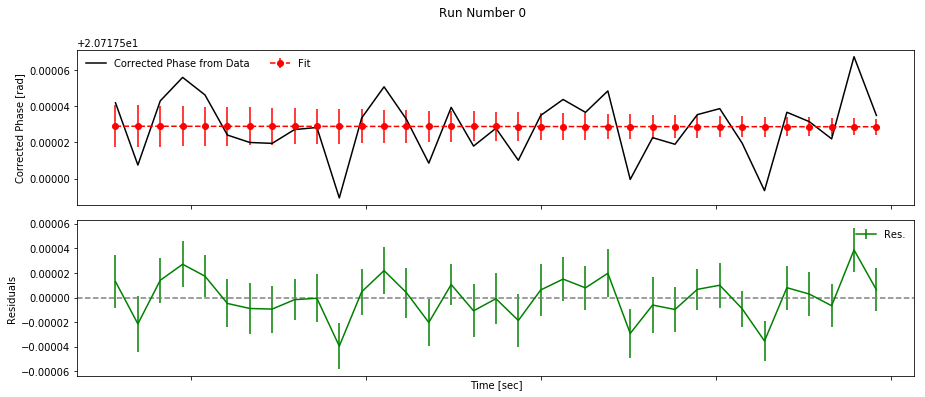

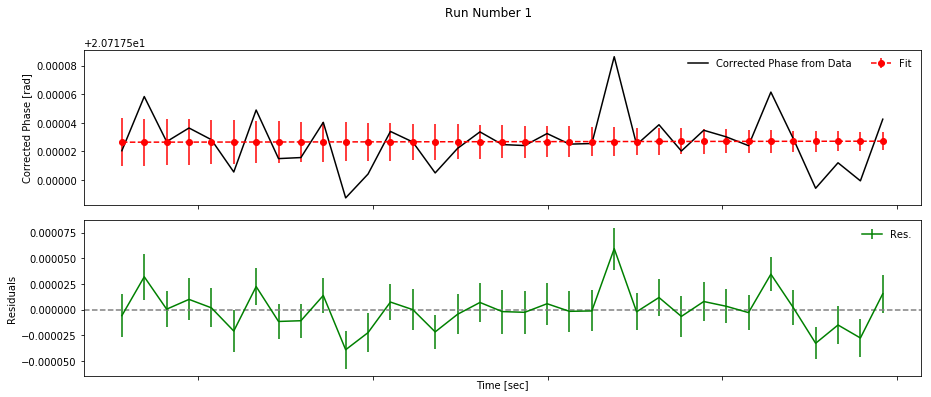

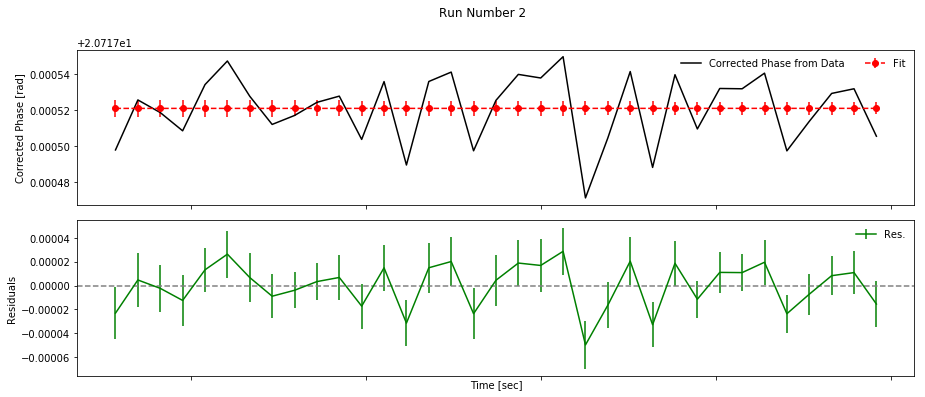

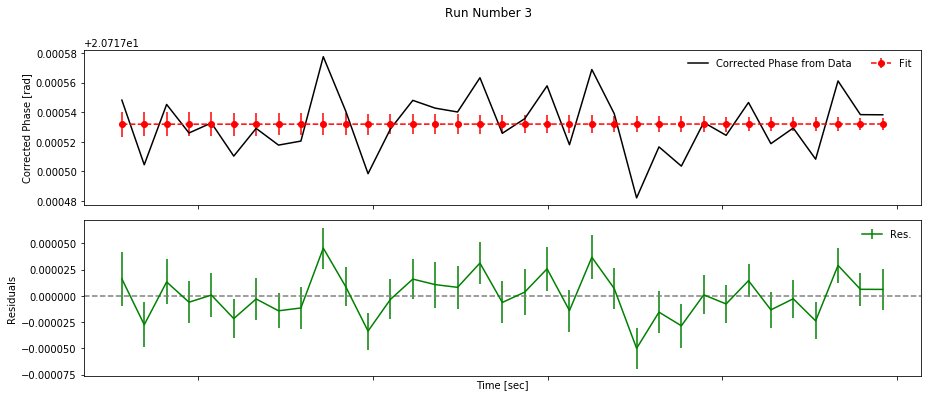

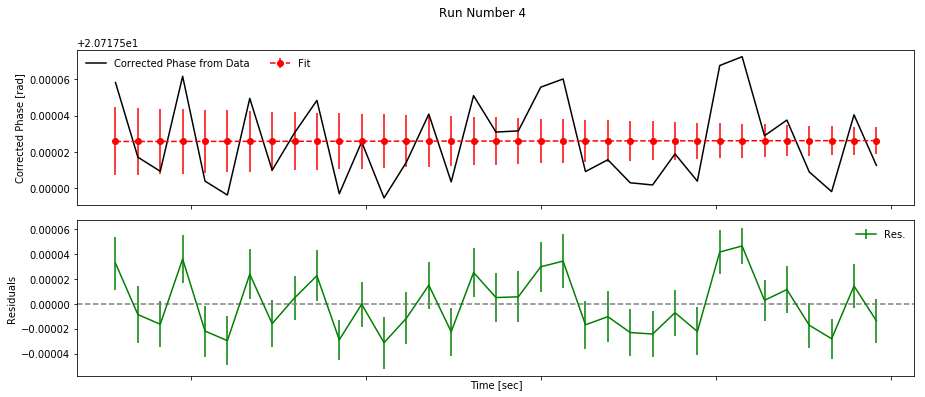

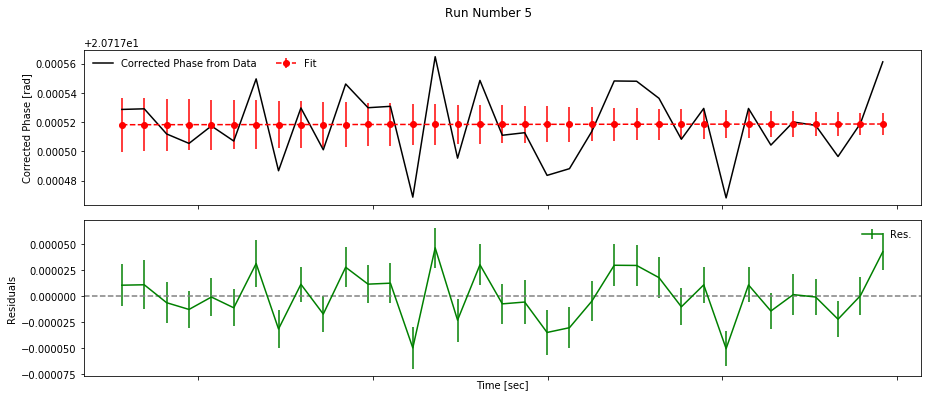

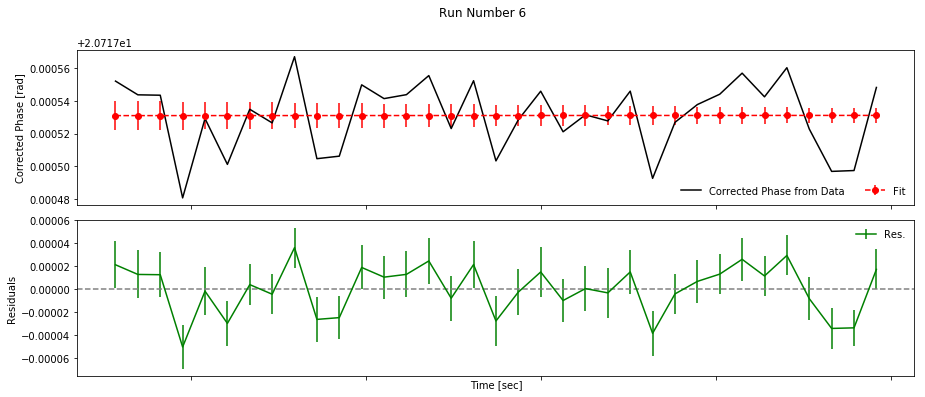

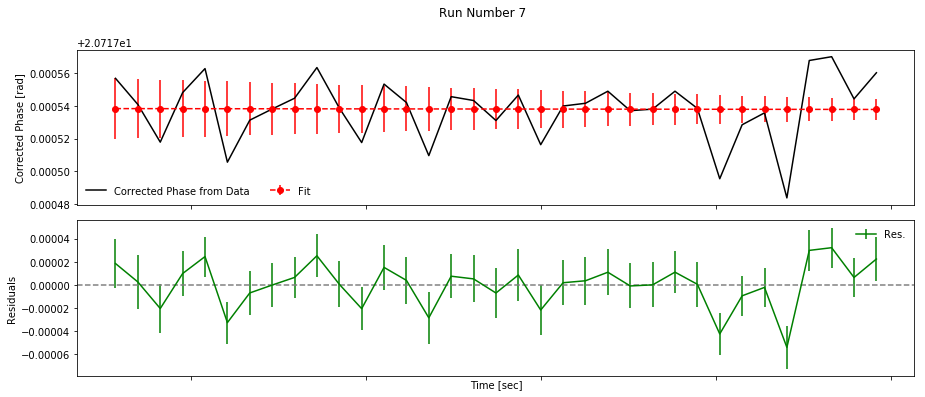

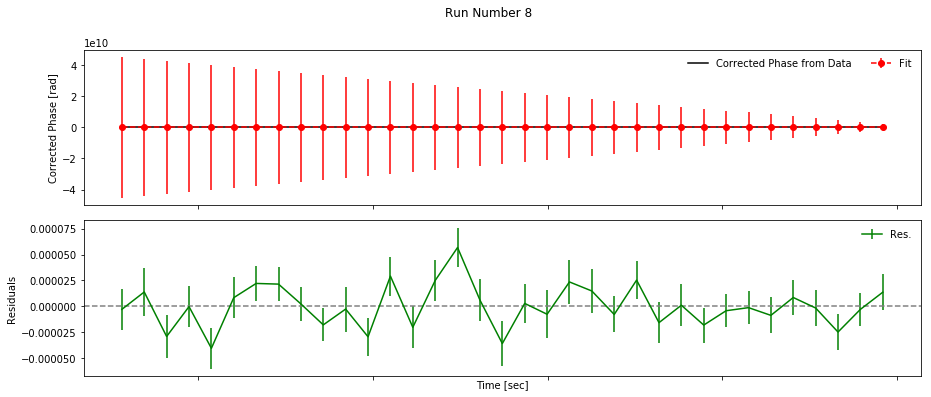

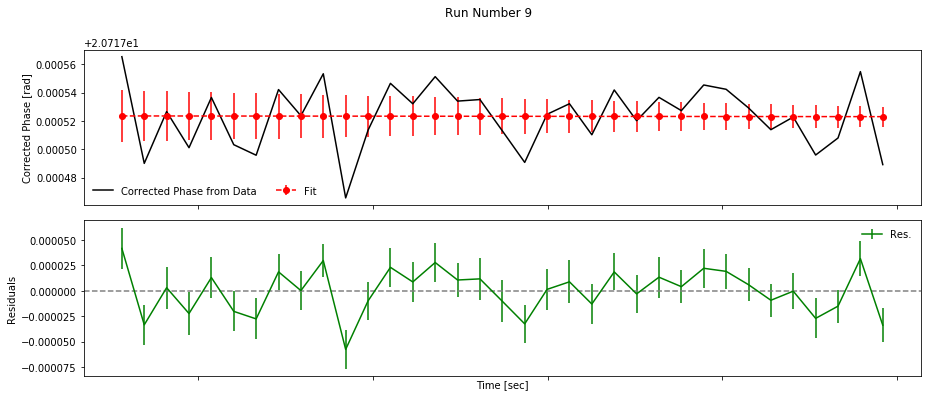

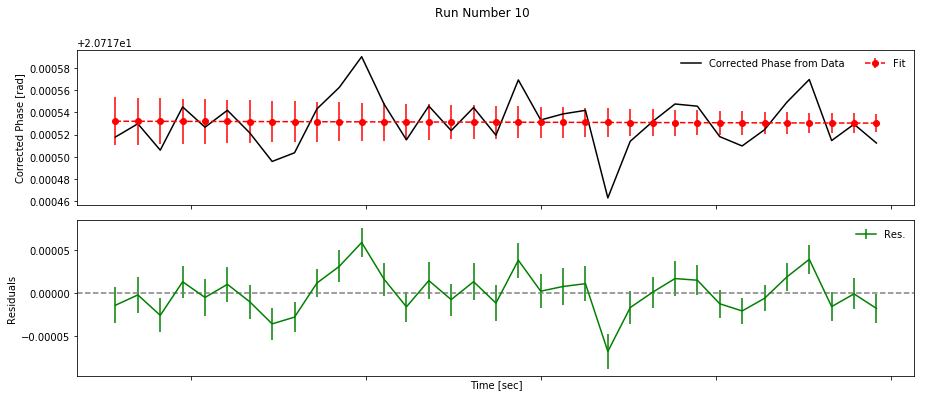

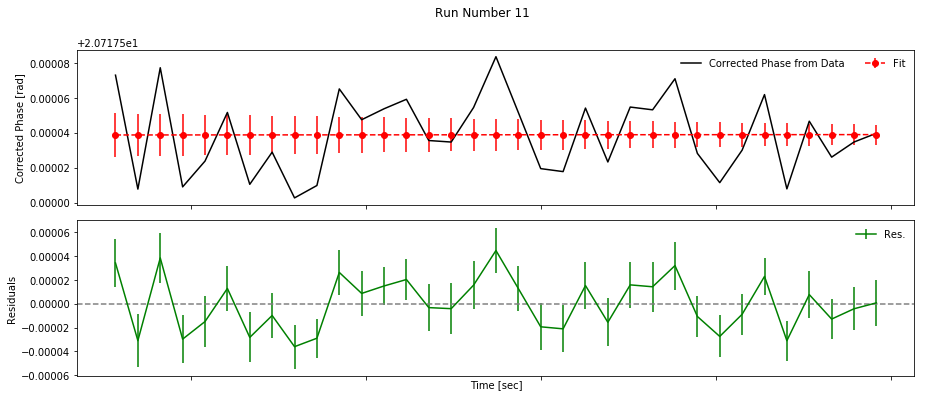

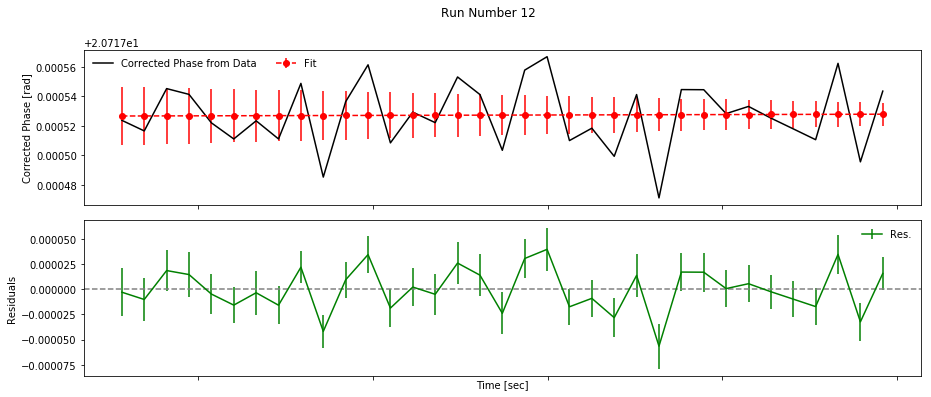

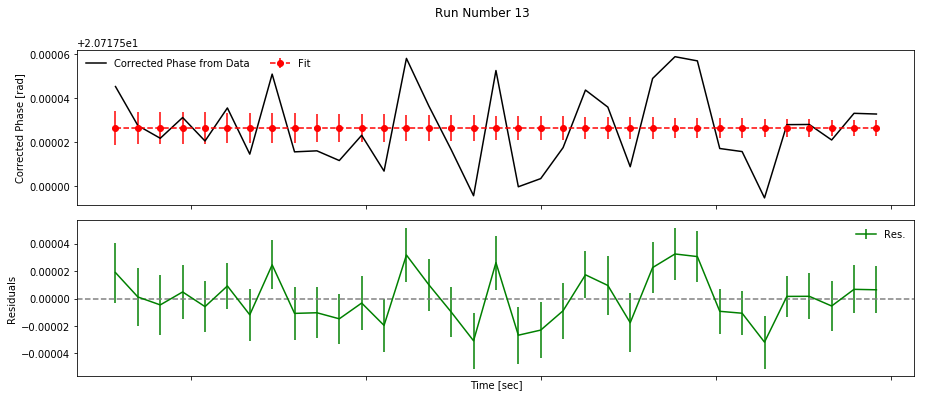

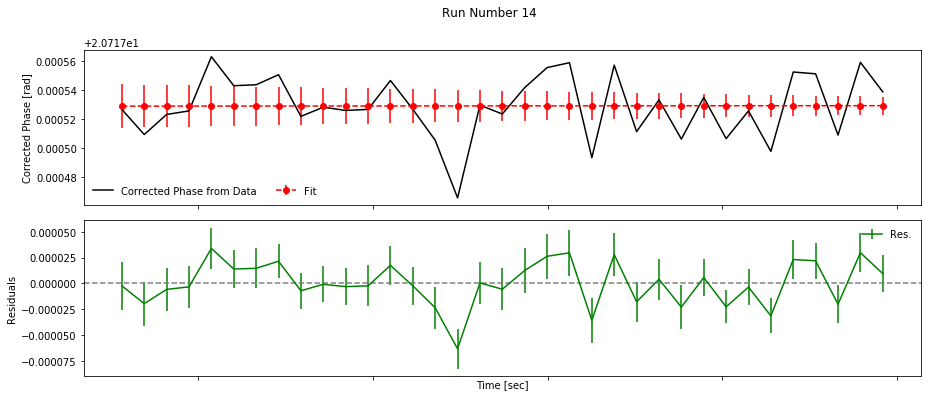

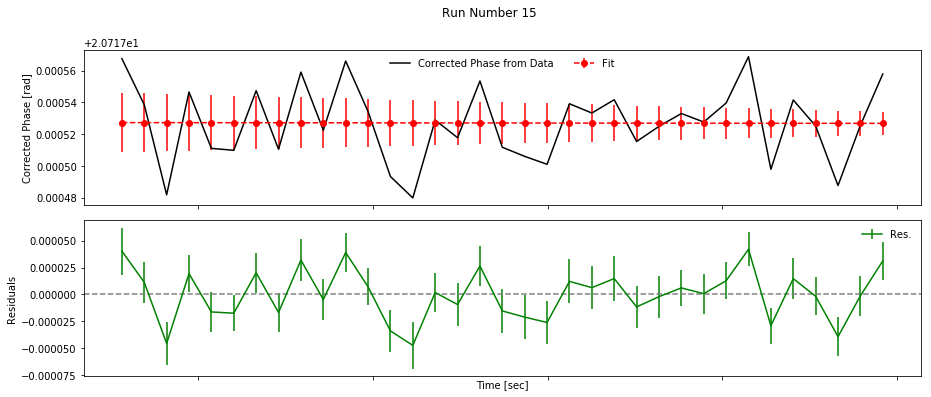

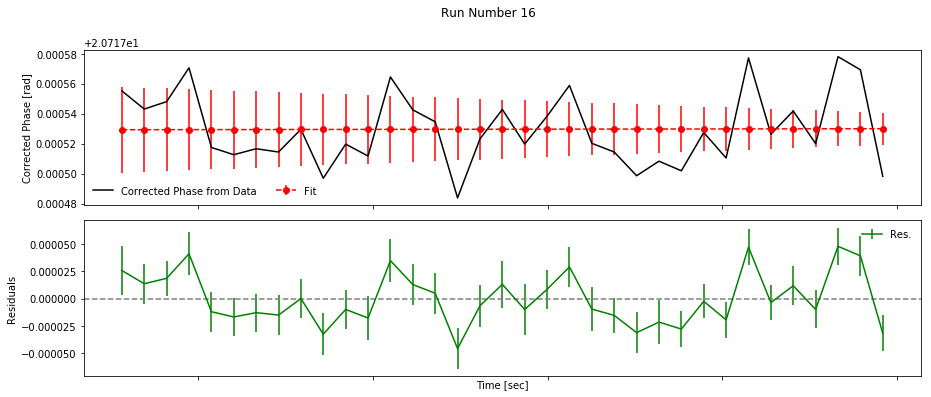

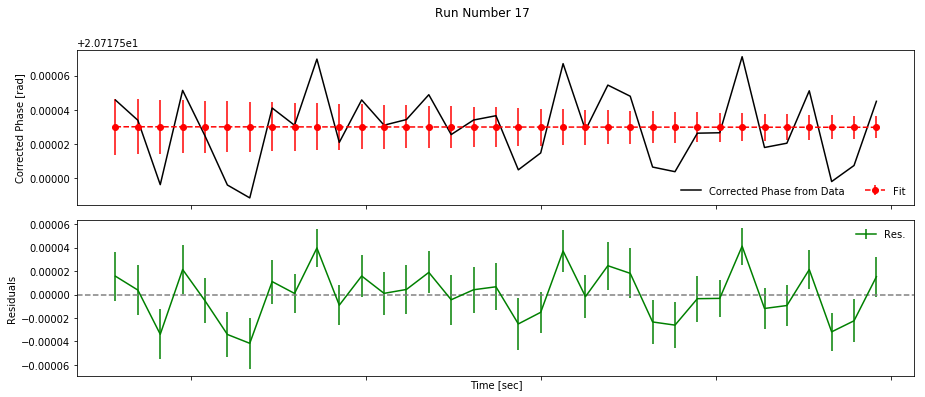

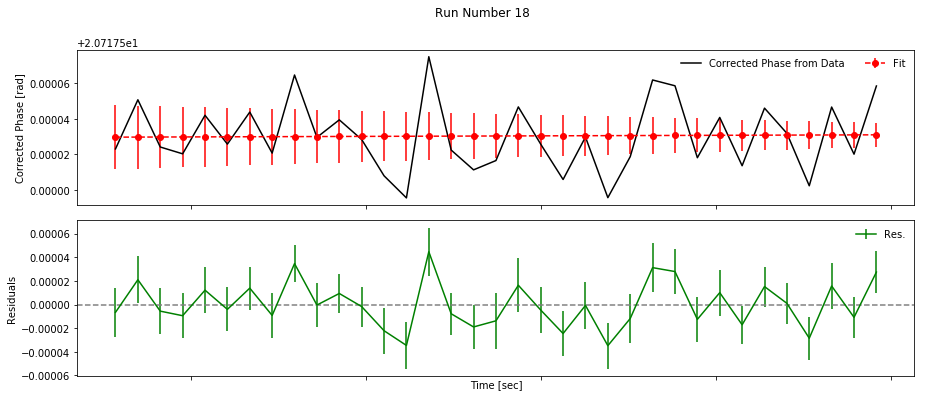

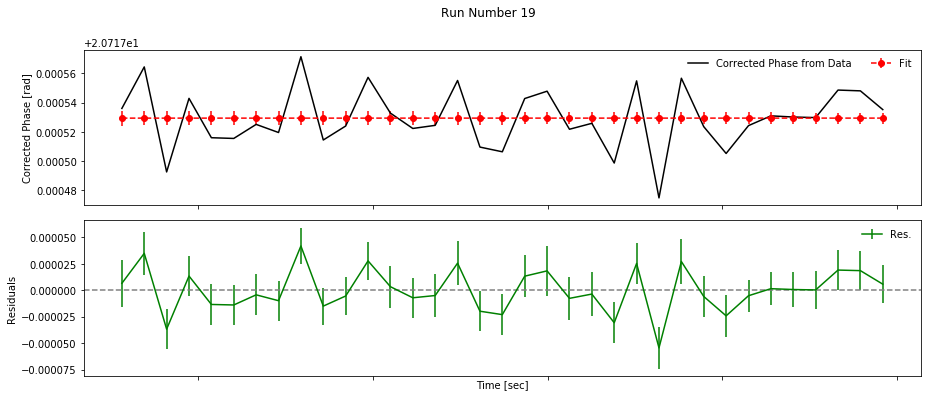

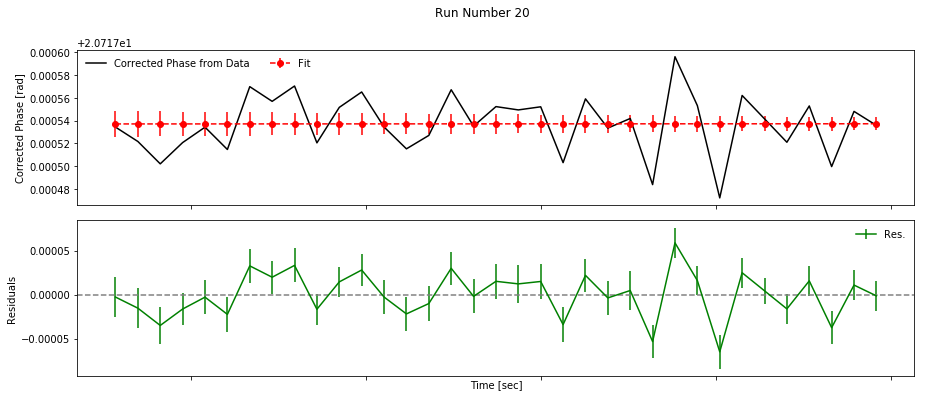

In [6]:
for k_ind in range(ks1, ks2+1):
    i = k_ind - ks1
    plt.figure();
    f, ax_arr = plt.subplots(2, 1)
    f.suptitle("Run Number " + str(k_ind) )
    ax_arr[0].plot( times, cp_arr_all[i], c="black", label="Corrected Phase from Data")
    ax_arr[0].errorbar( times, cp_fitresults_arr[i], np.amax( (np.abs(cp_fiterr_arr[i][1]+cp_fiterr_arr[i][0]*times), np.abs(cp_fiterr_arr[i][1]-cp_fiterr_arr[i][0]*times)), axis=0), c="red", ls="--", label="Fit", marker="o")
    ax_arr[1].errorbar( times, (cp_arr_all[i] - cp_fitresults_arr[i]), cp_err_all[i], c="green", label="Res.")
    ax_arr[1].axhline(0, ls="--", c="grey")
    ax_arr[0].legend(frameon=False, ncol=2 )
    ax_arr[1].legend(frameon=False, ncol=2 )
    ax_arr[1].set_xlabel("Time [sec]")
    ax_arr[0].set_ylabel("Corrected Phase [rad]")
    ax_arr[1].set_ylabel("Residuals")
    plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
    f.subplots_adjust(hspace=0.1)

Text(0.5,0,'Run Number')

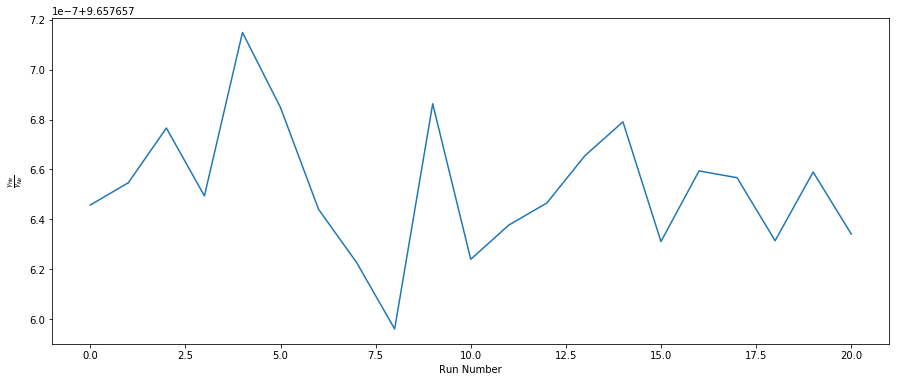

In [7]:
plt.plot(r_arr)
plt.ylabel("$\\frac{\\gamma_{He}}{\\gamma_{Ne}}$")
plt.xlabel("Run Number")

Text(0.5,1,'$\\omega_{corr} \\, \\chi^2$ histogram')

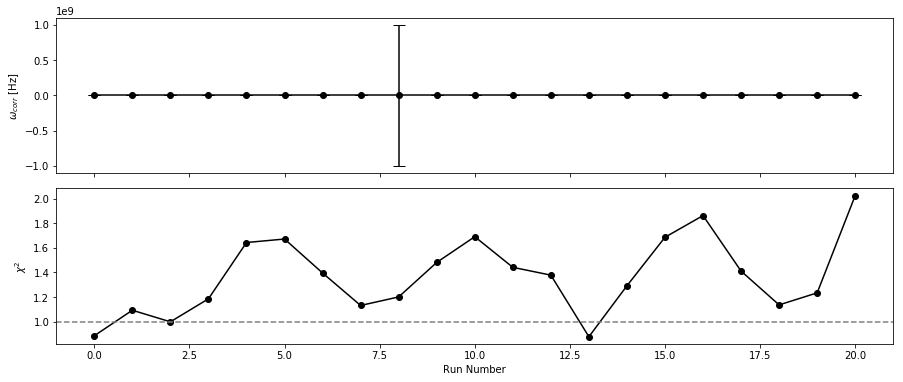

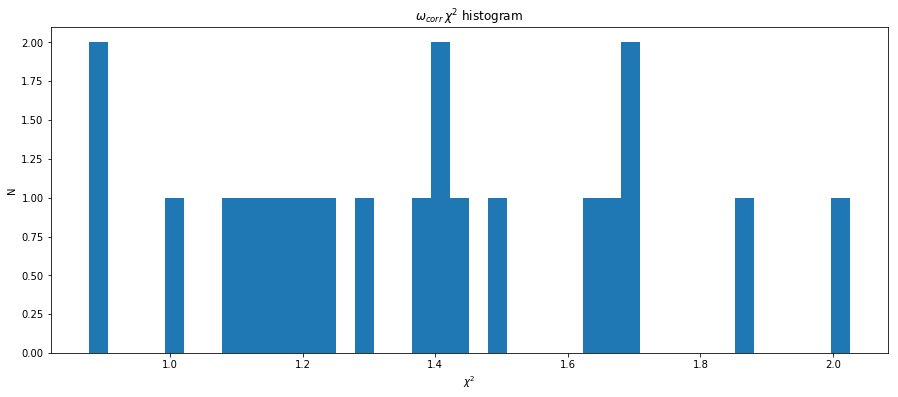

In [8]:
f, ax_arr = plt.subplots(2, 1)
ax_arr[0].errorbar(np.arange(len(cp_fit_arr)), cp_fit_arr[:,0], cp_fiterr_arr[:,0], fmt="o", ls="-", c="black", markersize=6, capsize=6)
ax_arr[0].set_ylabel("$\omega_{corr}$ [Hz]")
ax_arr[1].plot(np.arange(len(cp_fit_arr)), cpchi2_arr, marker=".", markersize=12, color="black")
ax_arr[1].set_ylabel("$\chi^2$")
ax_arr[1].set_xlabel("Run Number")
ax_arr[1].axhline(1, ls="--", c="grey")
plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
f.subplots_adjust(hspace=0.1)

plt.figure()
plt.hist(cpchi2_arr[cpchi2_arr<100], bins=40)
plt.xlabel("$\chi^2$")
plt.ylabel("N")
plt.title("$\omega_{corr} \, \chi^2$ histogram")